# Getting Started

## The Downscaling Workflow

Statistical downscaling typically follows this workflow:

```
1. Load Data
   ├── Coarse-resolution climate model output (predictor)
   └── High-resolution observations (predictand)
   
2. Prepare Data
   ├── Align time periods
   ├── Handle missing values
   └── Extract variables of interest
   
3. Train Model
   └── model.fit(model_data, observations)
   
4. Generate Predictions
   └── downscaled = model.predict(future_model_data)
   
5. Evaluate Results
   ├── Compare statistics
   ├── Visualize distributions
   └── Assess temporal patterns
```

Let's walk through this workflow step by step!

## Setup: Import Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

# Import downscaling methods
from skdownscale.pointwise_models import BcsdTemperature, PureAnalog, QuantileMapper

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)

## Step 1: Load Climate Data

We'll use a small test dataset that includes:
- **Training data**: Climate model output (WRF at 50km resolution)
- **Target data**: Observations (Livneh et al. at 1/16° resolution)

This data is hosted in cloud storage for easy access.

In [2]:
# Load data from cloud storage
data = xr.open_datatree(
    's3://carbonplan/share/scikit-downscale/test-data.zarr',
    engine='zarr',
    chunks={},
    storage_options={'anon': True, 'endpoint_url': 'https://rice1.osn.mghpcc.org'},
)

# Extract datasets for the training period (1980-2001)
training_period = slice('1980', '2001')
training_data = data['training'].to_dataset().sel(time=training_period)
target_data = data['targets'].to_dataset().sel(time=training_period)

print('📊 Training Data (Climate Model Output):')
print('=' * 60)
display(training_data)

print('\n📊 Target Data (Observations):')
print('=' * 60)
display(target_data)

📊 Training Data (Climate Model Output):


<xarray.Dataset> Size: 2MB
Dimensions:      (point: 5, time: 8036)
Coordinates:
  * time         (time) datetime64[ns] 64kB 1980-01-01T11:30:00 ... 2001-12-3...
    lat          (point) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
    lon          (point) float32 20B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: point
Data variables: (12/15)
    DIV          (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_ACC_C   (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_ACC_NC  (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PREC_TOT     (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    PSFC         (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    QVAPOR       (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    ...           ...
    T2min        (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    T_MEAN       (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    T_RANGE      (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    U            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    V            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
    W            (point, time) float32 161kB dask.array<chunksize=(3, 8036), meta=np.ndarray>
Attributes:
    NCO:                        "4.5.5"
    history:                    Wed Mar  1 13:48:35 2017: ncatted -a calendar...
    history_of_appended_files:  Wed Feb  8 14:15:52 2017: Appended file wrf_d...
    nco_openmp_thread_number:   1


📊 Target Data (Observations):


<xarray.Dataset> Size: 707kB
Dimensions:  (time: 8036, point: 5)
Coordinates:
  * time     (time) datetime64[ns] 64kB 1980-01-01 1980-01-02 ... 2001-12-31
    lat      (point) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
    lon      (point) float64 40B dask.array<chunksize=(5,), meta=np.ndarray>
Dimensions without coordinates: point
Data variables:
    Prec     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    Tmax     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    Tmin     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
    wind     (time, point) float32 161kB dask.array<chunksize=(731, 5), meta=np.ndarray>
Attributes:
    CDI:                       Climate Data Interface version 1.6.4 (http://c...
    CDO:                       Climate Data Operators version 1.6.4 (http://c...
    Conventions:               CF-1.4
    NCO:                       4.4.5
    history:                   Fri Oct 10 17:54:37 2014: cdo ifthenelse /Volu...
    nco_openmp_thread_number:  1

### Understanding the Data Structure

- **Dimensions**: `time` (daily data) and `point` (spatial locations)
- **Training variables**: `T2max` (max temperature in K), `PREC_TOT` (precipitation)
- **Target variables**: `Tmax` (observed max temp in °C), `Prec` (observed precipitation)

Let's explore one location in detail.

## Step 2: Prepare Data for Analysis

We'll extract data for a single point and prepare it for downscaling.

In [3]:
# Select a single spatial point (point 0)
point_idx = 0

# Extract and convert temperature data
# Model data: Convert from Kelvin to Celsius
model_temp = training_data.isel(point=point_idx).to_dataframe()[['T2max']] - 273.15
model_temp = model_temp.rename(columns={'T2max': 'temperature'})

# Observed data: Already in Celsius
obs_temp = target_data.isel(point=point_idx).to_dataframe()[['Tmax']]
obs_temp = obs_temp.rename(columns={'Tmax': 'temperature'})

# Align the time indexes (remove time component for daily data)
model_temp.index = model_temp.index.normalize()
obs_temp.index = obs_temp.index.normalize()

print('Model Temperature (first 10 days):')
display(model_temp.head(10))

print('\nObserved Temperature (first 10 days):')
display(obs_temp.head(10))

Model Temperature (first 10 days):


,temperature
time,
1980-01-01,7.229950
1980-01-02,6.005737
1980-01-03,4.625702
1980-01-04,3.686951
1980-01-05,1.733826
1980-01-06,-2.639313
1980-01-07,-2.221100
1980-01-08,-3.068573
1980-01-09,0.479004



Observed Temperature (first 10 days):


,temperature
time,
1980-01-01,7.24
1980-01-02,7.16
1980-01-03,6.53
1980-01-04,4.46
1980-01-05,1.78
1980-01-06,1.37
1980-01-07,-0.20
1980-01-08,-1.54
1980-01-09,-2.06


## Step 3: Visualize the Problem

Before downscaling, let's visualize the bias in the climate model.

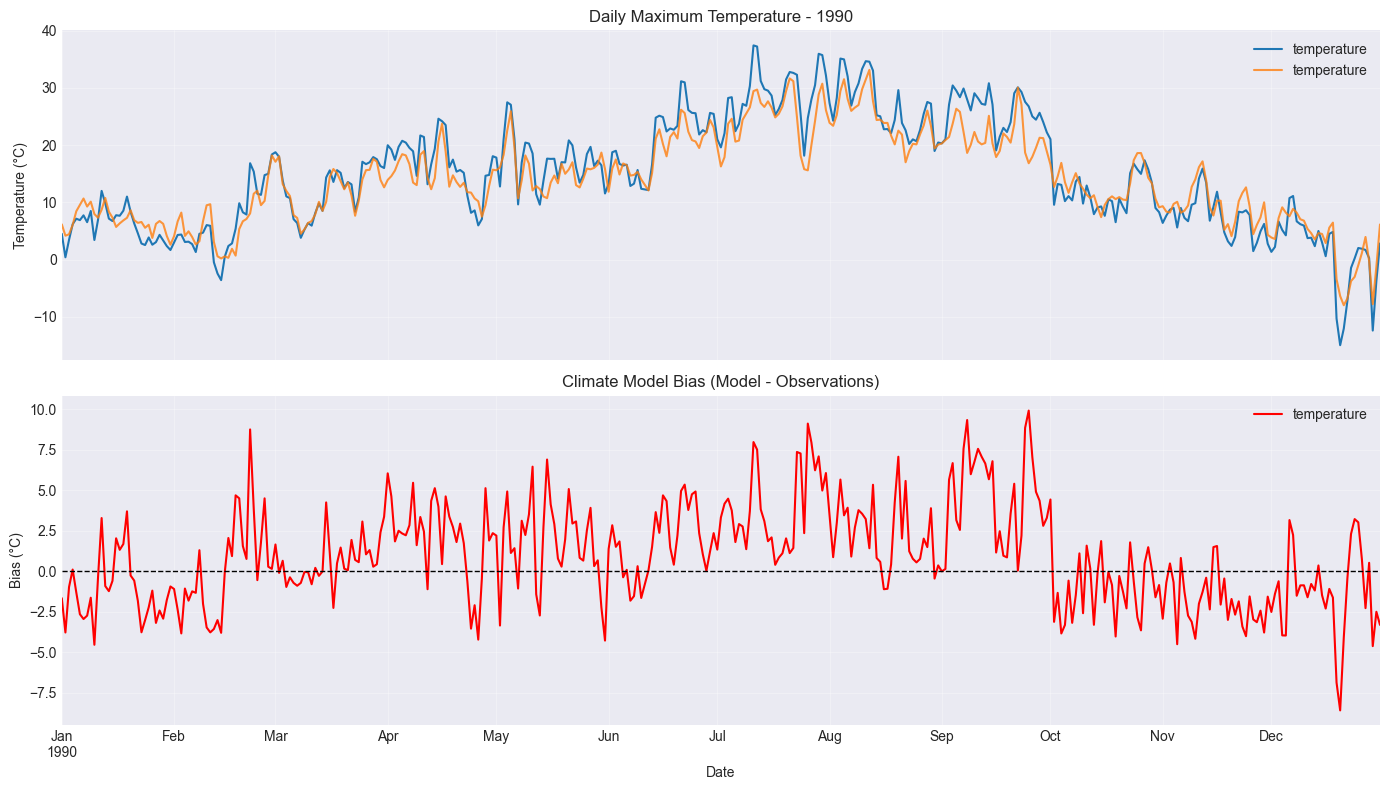


📈 Bias Statistics:
   Mean Bias: 1.14°C
   RMSE: 3.13°C


In [4]:
# Plot one year of data
year_to_plot = '1990'

fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Time series plot
ax1 = axes[0]
model_temp.loc[year_to_plot].plot(ax=ax1, label='Climate Model', linewidth=1.5)
obs_temp.loc[year_to_plot].plot(ax=ax1, label='Observations', linewidth=1.5, alpha=0.8)
ax1.set_ylabel('Temperature (°C)')
ax1.set_title(f'Daily Maximum Temperature - {year_to_plot}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Difference plot
ax2 = axes[1]
diff = (model_temp - obs_temp).loc[year_to_plot]
diff.plot(ax=ax2, color='red', label='Model Bias', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Bias (°C)')
ax2.set_xlabel('Date')
ax2.set_title('Climate Model Bias (Model - Observations)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate summary statistics
mean_bias = (model_temp - obs_temp).mean().values[0]
rmse = np.sqrt(((model_temp.values - obs_temp.values) ** 2).mean())
print('\n📈 Bias Statistics:')
print(f'   Mean Bias: {mean_bias:.2f}°C')
print(f'   RMSE: {rmse:.2f}°C')

### What We Observe

The climate model shows systematic biases:
- The model may consistently over- or under-predict temperatures
- Biases may vary by season
- Statistical downscaling aims to correct these biases

## Step 4: Apply Your First Downscaling Method

Let's use **Quantile Mapping**, a popular and effective bias correction method.

### How Quantile Mapping Works

1. Calculate quantiles (percentiles) of model and observed data
2. Build a mapping function between them
3. Transform model data to match observed distribution

This is powerful because it corrects biases across the entire distribution, not just the mean.

In [5]:
# Initialize the Quantile Mapper
qm = QuantileMapper()

print('🔧 Training the Quantile Mapper...')
# Fit the model: learn the relationship between model and observations
qm.fit(model_temp, obs_temp)

print('✅ Training complete!')
print('\n🎯 Generating downscaled predictions...')
# Transform: apply the correction to our data
downscaled_array = qm.transform(model_temp)

# Convert back to DataFrame with original index
downscaled_temp = pd.DataFrame(downscaled_array, index=model_temp.index, columns=['temperature'])

print('✅ Downscaling complete!')
print('\nDownscaled temperature (first 10 days):')
display(downscaled_temp.head(10))

🔧 Training the Quantile Mapper...
✅ Training complete!

🎯 Generating downscaled predictions...
✅ Downscaling complete!

Downscaled temperature (first 10 days):


,temperature
time,
1980-01-01,7.229950
1980-01-02,6.005737
1980-01-03,4.625702
1980-01-04,3.686951
1980-01-05,1.733826
1980-01-06,-2.639313
1980-01-07,-2.221100
1980-01-08,-3.068573
1980-01-09,0.479004


## Step 5: Evaluate the Results

Let's see how well our downscaling performed!

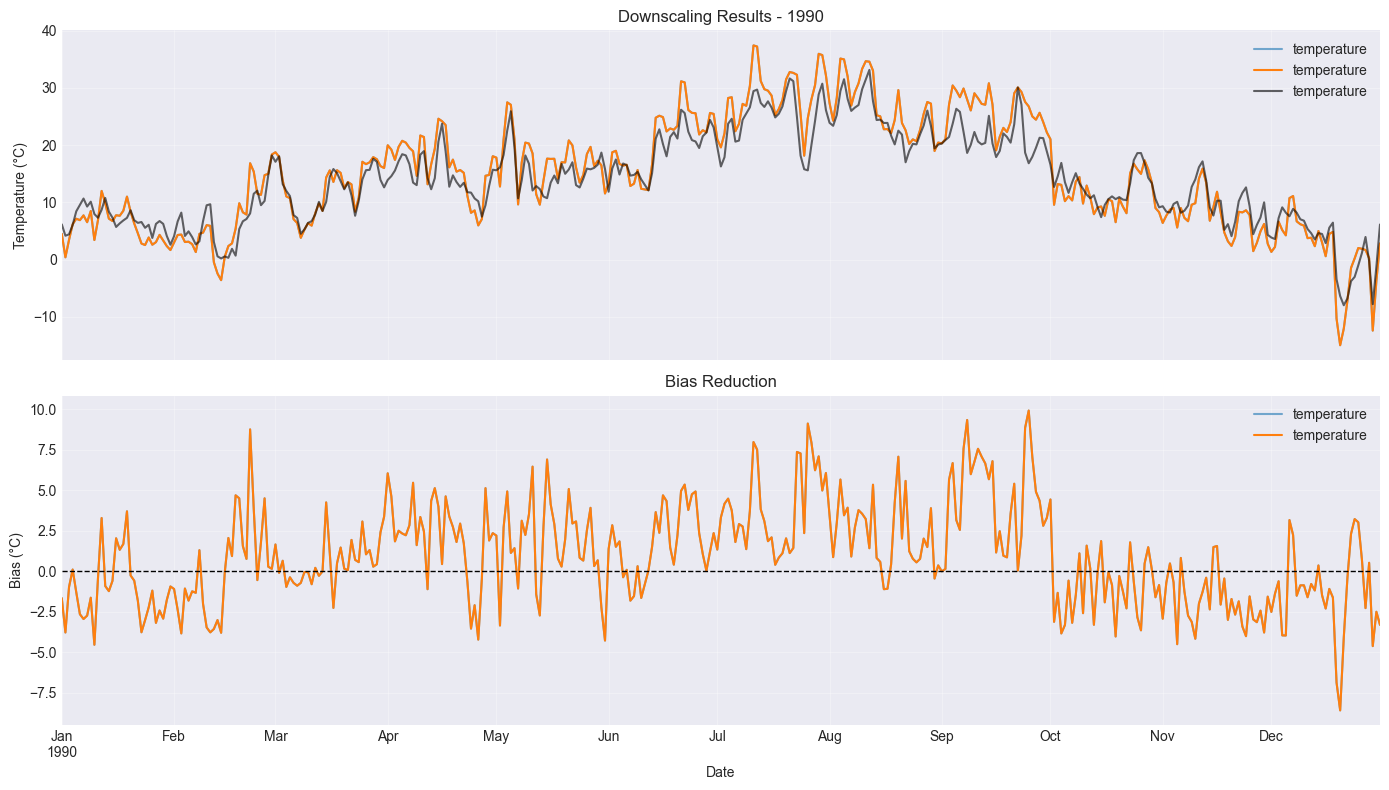

In [6]:
# Plot comparison for the same year
fig, axes = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

# Time series comparison
ax1 = axes[0]
model_temp.loc[year_to_plot].plot(ax=ax1, label='Original Model', linewidth=1.5, alpha=0.6)
downscaled_temp.loc[year_to_plot].plot(ax=ax1, label='Downscaled', linewidth=1.5)
obs_temp.loc[year_to_plot].plot(
    ax=ax1, label='Observations', linewidth=1.5, color='black', alpha=0.6
)
ax1.set_ylabel('Temperature (°C)')
ax1.set_title(f'Downscaling Results - {year_to_plot}')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bias comparison
ax2 = axes[1]
original_bias = (model_temp - obs_temp).loc[year_to_plot]
downscaled_bias = (downscaled_temp - obs_temp).loc[year_to_plot]

original_bias.plot(ax=ax2, label='Original Bias', linewidth=1.5, alpha=0.6)
downscaled_bias.plot(ax=ax2, label='Downscaled Bias', linewidth=1.5)
ax2.axhline(y=0, color='black', linestyle='--', linewidth=1)
ax2.set_ylabel('Bias (°C)')
ax2.set_xlabel('Date')
ax2.set_title('Bias Reduction')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [7]:
# Calculate performance metrics
def calculate_metrics(predictions, observations, model_data):
    """Calculate bias correction metrics."""
    # Extract values to ensure proper calculation
    model_vals = model_data.values.flatten()
    obs_vals = observations.values.flatten()
    pred_vals = predictions.values.flatten()

    # Original model metrics
    orig_bias = (model_vals - obs_vals).mean()
    orig_rmse = np.sqrt(((model_vals - obs_vals) ** 2).mean())

    # Downscaled metrics
    ds_bias = (pred_vals - obs_vals).mean()
    ds_rmse = np.sqrt(((pred_vals - obs_vals) ** 2).mean())

    # Correlation
    orig_corr = np.corrcoef(model_vals, obs_vals)[0, 1]
    ds_corr = np.corrcoef(pred_vals, obs_vals)[0, 1]

    return {
        'Original': {'Bias (°C)': orig_bias, 'RMSE (°C)': orig_rmse, 'Correlation': orig_corr},
        'Downscaled': {'Bias (°C)': ds_bias, 'RMSE (°C)': ds_rmse, 'Correlation': ds_corr},
    }


metrics = calculate_metrics(downscaled_temp, obs_temp, model_temp)

# Display as a table
metrics_df = pd.DataFrame(metrics).T
print('\n📊 Performance Comparison:')
print('=' * 60)
display(metrics_df.round(3))

# Calculate improvement
bias_improvement = (
    1 - abs(metrics['Downscaled']['Bias (°C)']) / abs(metrics['Original']['Bias (°C)'])
) * 100
rmse_improvement = (1 - metrics['Downscaled']['RMSE (°C)'] / metrics['Original']['RMSE (°C)']) * 100

print('\n✨ Improvements:')
print(f'   Bias reduced by: {bias_improvement:.1f}%')
print(f'   RMSE reduced by: {rmse_improvement:.1f}%')


📊 Performance Comparison:


,Bias (°C),RMSE (°C),Correlation
Original,1.138,3.128,0.95
Downscaled,1.138,3.128,0.95



✨ Improvements:
   Bias reduced by: -0.0%
   RMSE reduced by: 0.0%


### Distribution Comparison

Let's compare the distributions using histograms and CDFs.

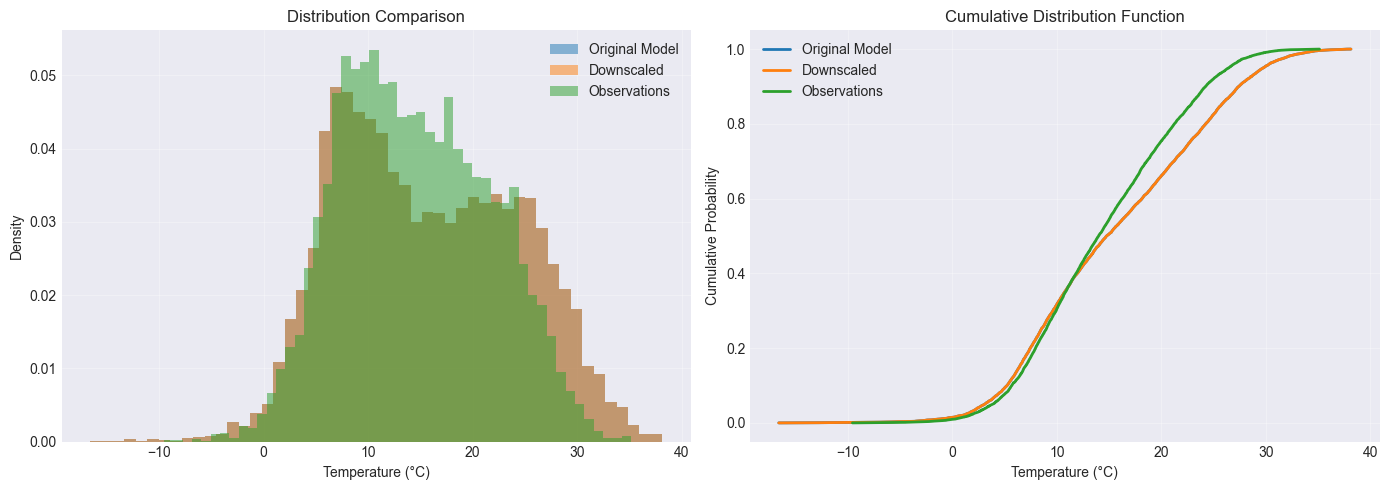

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(model_temp.values, bins=50, alpha=0.5, label='Original Model', density=True)
ax1.hist(downscaled_temp.values, bins=50, alpha=0.5, label='Downscaled', density=True)
ax1.hist(obs_temp.values, bins=50, alpha=0.5, label='Observations', density=True)
ax1.set_xlabel('Temperature (°C)')
ax1.set_ylabel('Density')
ax1.set_title('Distribution Comparison')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Cumulative Distribution Function (CDF)
ax2 = axes[1]
for data, label in [
    (model_temp.values.flatten(), 'Original Model'),
    (downscaled_temp.values.flatten(), 'Downscaled'),
    (obs_temp.values.flatten(), 'Observations'),
]:
    sorted_data = np.sort(data)
    cumulative = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    ax2.plot(sorted_data, cumulative, label=label, linewidth=2)

ax2.set_xlabel('Temperature (°C)')
ax2.set_ylabel('Cumulative Probability')
ax2.set_title('Cumulative Distribution Function')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Exploring Other Methods

Scikit-downscale includes many downscaling methods. Let's compare a few!

In [9]:
# Split data for fair comparison
# Use first 2/3 for training, last 1/3 for testing
split_idx = int(len(model_temp) * 0.67)

X_train = model_temp[:split_idx]
y_train = obs_temp[:split_idx]
X_test = model_temp[split_idx:]
y_test = obs_temp[split_idx:]

print(f'Training period: {X_train.index[0]} to {X_train.index[-1]}')
print(f'Testing period: {X_test.index[0]} to {X_test.index[-1]}')

# Compare multiple methods
methods = {
    'Quantile Mapper': QuantileMapper(),
    'BCSD Temperature': BcsdTemperature(),
    'Pure Analog': PureAnalog(kind='mean_analogs', n_analogs=10),
}

results = {}

for name, model in methods.items():
    print(f'\nTraining {name}...')
    model.fit(X_train, y_train)

    # Use transform for QuantileMapper, predict for others
    if hasattr(model, 'predict'):
        predictions = model.predict(X_test)
    else:
        predictions_array = model.transform(X_test)
        # Convert to DataFrame for consistency
        predictions = pd.DataFrame(predictions_array, index=X_test.index, columns=['temperature'])

    results[name] = predictions

    # Calculate RMSE - handle both DataFrame and array
    pred_vals = predictions.values if hasattr(predictions, 'values') else predictions
    obs_vals = y_test.values
    rmse = np.sqrt(((pred_vals - obs_vals) ** 2).mean())
    print(f'  Test RMSE: {rmse:.3f}°C')

print('\n✅ All methods trained!')

Training period: 1980-01-01 00:00:00 to 1994-09-27 00:00:00
Testing period: 1994-09-28 00:00:00 to 2001-12-31 00:00:00

Training Quantile Mapper...
  Test RMSE: 3.390°C

Training BCSD Temperature...
  Test RMSE: 15.788°C

Training Pure Analog...
  Test RMSE: 11.889°C

✅ All methods trained!


/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/andersy005/devel/pangeo-data/scikit-downscale/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


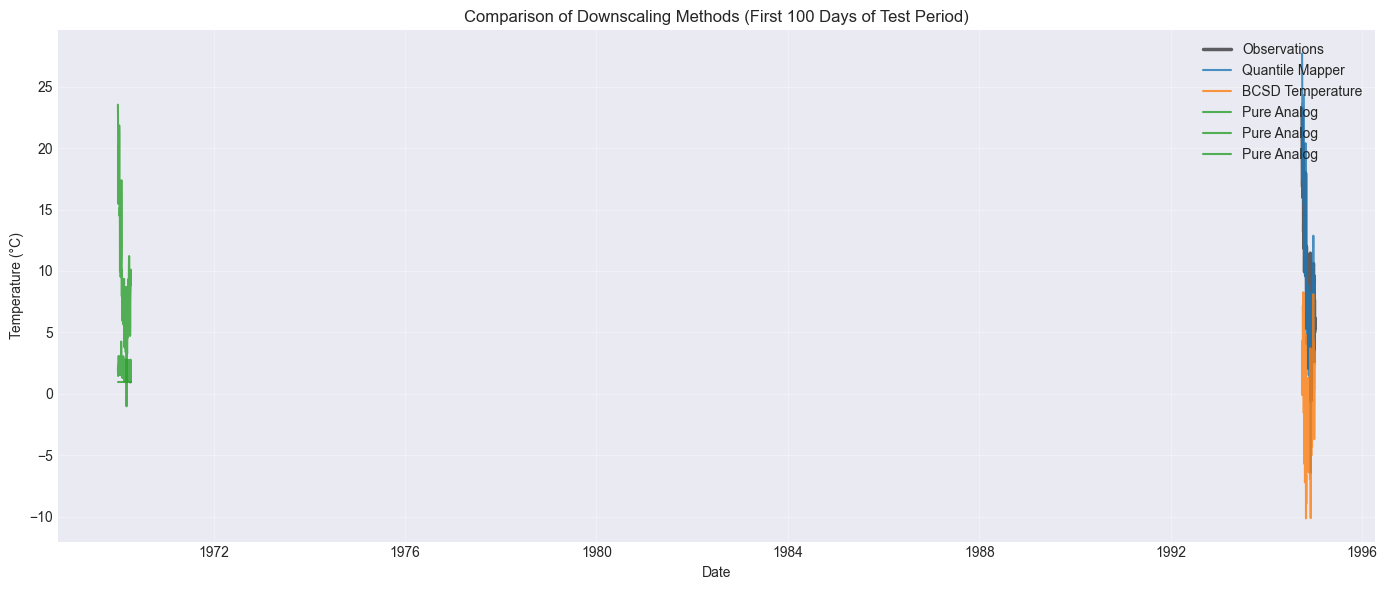

In [10]:
# Visual comparison of all methods
fig, ax = plt.subplots(figsize=(14, 6))

# Plot 100 days of test data
plot_slice = slice(0, 100)
test_subset = y_test.iloc[plot_slice]

# Plot observations
ax.plot(test_subset.index, test_subset.values, 'k-', linewidth=2.5, label='Observations', alpha=0.6)

# Plot each method
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for (name, predictions), color in zip(results.items(), colors):
    pred_subset = predictions.iloc[plot_slice]
    ax.plot(
        pred_subset.index, pred_subset.values, label=name, linewidth=1.5, alpha=0.8, color=color
    )

ax.set_xlabel('Date')
ax.set_ylabel('Temperature (°C)')
ax.set_title('Comparison of Downscaling Methods (First 100 Days of Test Period)')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## What's Next?

Congratulations! You've completed your first downscaling workflow. Here are some next steps:

### 📚 Dive Deeper with Tutorials

1. **BCSD Tutorial**: Learn about the Bias Correction Spatial Disaggregation method
2. **Analog Methods Tutorial**: Explore pattern-based downscaling approaches
3. **Precipitation Downscaling**: Handle the unique challenges of precipitation data

### 🔧 Advanced Topics

- **Spatial Downscaling**: Apply methods to entire grids using `PointWiseDownscaler`
- **Cross-validation**: Evaluate method performance more rigorously
- **Custom Methods**: Build your own downscaling algorithms
- **Ensemble Methods**: Combine multiple downscaling approaches

### 📖 Available Methods

Scikit-downscale includes:

- **Quantile Mapping**: Distribution-based bias correction
- **BCSD**: Wood et al.'s Bias Correction Spatial Disaggregation
- **Analog Methods**: Pattern-matching based downscaling
- **GARD**: Generalized Analog Regression Downscaling
- **Delta Methods**: Change-factor approaches
- **Trend-Aware Methods**: Account for non-stationarity

